# Analysis of HDB Prices Near Expressways (Part 2)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import time
import requests
import json

# from pykml import parser
# from lxml import etree

# 5. Linear Regression Analysis

Additional processing of the dataset was performed in Excel. 
- A new categorical column `distance_from_expressway` was created, based on earlier columns relating to the distance of the flat from a highway.
- This column contains the following values: `'<=50m', '51-100m', '101-150m', '151-300m', '301-500m', '>500m'`

In [3]:
df_hdb_resale_cleaned = pd.read_csv("hdb_presale_prices_2015-2024_cleaned_regression.csv")

print(df_hdb_resale_cleaned.shape)
df_hdb_resale_cleaned.head()

(220971, 11)


,year,town,flat_type,block,street_name,storey_range,floor_area_sqm,remaining_lease_years,resale_price,storey_range_category,distance_from_expressway
0,2017,ANG MO KIO,2 ROOM,406,ANG MO KIO AVENUE 10,10 TO 12,44.0,61,232000.0,Low-Mid (07-12),>500m
1,2017,ANG MO KIO,3 ROOM,108,ANG MO KIO AVENUE 4,01 TO 03,67.0,60,250000.0,Low (01-06),>500m
2,2017,ANG MO KIO,3 ROOM,602,ANG MO KIO AVENUE 5,01 TO 03,67.0,62,262000.0,Low (01-06),>500m
3,2017,ANG MO KIO,3 ROOM,465,ANG MO KIO AVENUE 10,04 TO 06,68.0,62,265000.0,Low (01-06),151-300m
4,2017,ANG MO KIO,3 ROOM,601,ANG MO KIO AVENUE 5,01 TO 03,67.0,62,265000.0,Low (01-06),>500m


In [4]:
# One-hot encode the 'distance_from_expressway', 'storey_range_category' & 'flat_type' column
df_encoded = pd.get_dummies(df_hdb_resale_cleaned, columns=['distance_from_expressway', 'storey_range_category', 'flat_type'], drop_first=False)

# Drop the reference columns after one-hot-encoding
# Sale transactions >500m away (far away) from expressways will be used as the point of reference
# The lowest storey category (level 1 to 6) will be used as the point of reference
# A 3-room flat will be used as the point of reference
df_encoded = df_encoded.drop(columns=['distance_from_expressway_>500m', 'storey_range_category_Low (01-06)', 'flat_type_3 ROOM'])

# Convert boolean columns to integers
bool_columns = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

print(df_encoded.shape)
df_encoded.head()

(220971, 23)


,year,town,block,street_name,storey_range,floor_area_sqm,remaining_lease_years,resale_price,distance_from_expressway_101-150m,distance_from_expressway_151-300m,...,storey_range_category_High (19-30),storey_range_category_Low-Mid (07-12),storey_range_category_Mid (13-18),storey_range_category_Very High (>30),flat_type_1 ROOM,flat_type_2 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION
0,2017,ANG MO KIO,406,ANG MO KIO AVENUE 10,10 TO 12,44.0,61,232000.0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,2017,ANG MO KIO,108,ANG MO KIO AVENUE 4,01 TO 03,67.0,60,250000.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017,ANG MO KIO,602,ANG MO KIO AVENUE 5,01 TO 03,67.0,62,262000.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017,ANG MO KIO,465,ANG MO KIO AVENUE 10,04 TO 06,68.0,62,265000.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2017,ANG MO KIO,601,ANG MO KIO AVENUE 5,01 TO 03,67.0,62,265000.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(df_encoded.columns.tolist())

['year', 'town', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'remaining_lease_years', 'resale_price', 'distance_from_expressway_101-150m', 'distance_from_expressway_151-300m', 'distance_from_expressway_301-500m', 'distance_from_expressway_51-100m', 'distance_from_expressway_<=50m', 'storey_range_category_High (19-30)', 'storey_range_category_Low-Mid (07-12)', 'storey_range_category_Mid (13-18)', 'storey_range_category_Very High (>30)', 'flat_type_1 ROOM', 'flat_type_2 ROOM', 'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE', 'flat_type_MULTI-GENERATION']


A correlation matrix was drawn to observe the correlation of numerical variables. 
- Overall, it appears that there is no significant correlation between the exogenous numerical variables.
- There is some low-moderate correlation among floor_area_sqm, remaining_lease_years, higher storey categories with resale_price, which is expected given that these factors could influence housing prices.

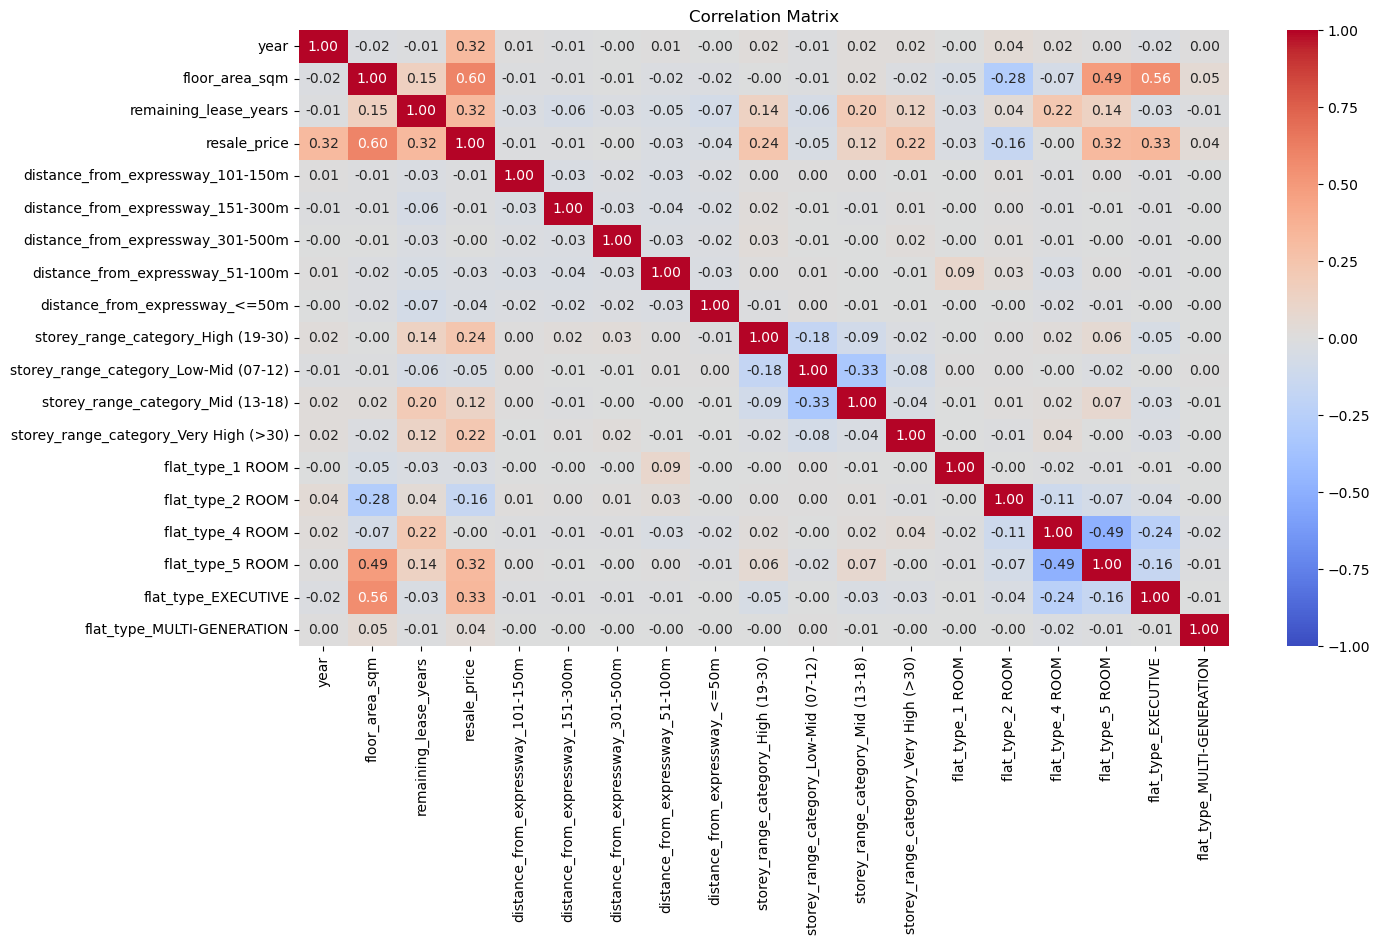

In [169]:
# Compute the correlation matrix for numerical variables
# correlation_matrix = df_encoded[['year', 'floor_area_sqm', 'remaining_lease_years', 'resale_price']].corr()
correlation_matrix = df_encoded.select_dtypes(include='number').corr()

# Plot the correlation matrix using Seaborn
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## 5.1 Baseline Linear Regression

First, in order to assess if proximity to expressways influence overall HDB resale prices, a baseline regression involving only `distance_from_expressway` as the exogenous variable is conducted.

In [6]:
import statsmodels.api as sm

In [7]:
# Exogenous variable (encoded distance from expressway)
X = df_encoded[['distance_from_expressway_<=50m', 'distance_from_expressway_51-100m', 'distance_from_expressway_101-150m', 'distance_from_expressway_151-300m', 'distance_from_expressway_301-500m']]

# Add a constant to X (for y-intercept)
X = sm.add_constant(X)

# Endogenous variable (resale price)
y = df_encoded['resale_price']

# Fit the linear regression model
model_base = sm.OLS(y, X).fit()

# Generate summary of the regression results
model_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     118.3
Date:                Mon, 05 Aug 2024   Prob (F-statistic):          1.87e-125
Time:                        10:42:48   Log-Likelihood:            -2.9749e+06
No. Observations:              220971   AIC:                         5.950e+06
Df Residuals:                  220965   BIC:                         5.950e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                              4.936e+05    389.497   1267.271      0.000    4.93e+05    4.94e+05
distance_from_expressway_<=50m    -5.442e+04   2867.743    -18.975      0.000      -6e+04   -4.88e+04
distance_from_expressway_51-100m  -2.702e+04   1873.996    -14.417      0.000   -3.07e+04   -2.33e+04
distance_from_expressway_101-150m -1.231e+04   2178.723     -5.648      0.000   -1.66e+04   -8035.631
distance_from_expressway_151-300m -1.036e+04   1961.031     -5.282      0.000   -1.42e+04   -6513.982
distance_from_expressway_301-500m -4390.9178   2734.904     -1.606      0.108   -9751.260     969.425
==============================================================================
Omnibus:                    32034.397   Durbin-Watson:                   0.310
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50918.038
Skew:                           1.011   Prob(JB):                         0.00
Kurtosis:                       4.202   Cond. No.                         7.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Extract coefficients and statistics
summary_df = pd.DataFrame({
    'coef': model_base.params,
    'std err': model_base.bse,
    't': model_base.tvalues,
    'P>|t|': model_base.pvalues,
    '0.025': model_base.conf_int()[0],
    '0.975': model_base.conf_int()[1]
})

# Reset the index to have the variable names as a column
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Variable'}, inplace=True)

# Display the summary DataFrame
summary_df


,Variable,coef,std err,t,P>|t|,0.025,0.975
0,const,493598.767065,389.497389,1267.271056,0.000000e+00,492835.362029,494362.172101
1,distance_from_expressway_<=50m,-54415.523483,2867.742720,-18.975037,3.178627e-80,-60036.226718,-48794.820247
2,distance_from_expressway_51-100m,-27016.613072,1873.995781,-14.416582,4.275807e-47,-30689.597430,-23343.628714
3,distance_from_expressway_101-150m,-12305.872529,2178.722895,-5.648205,1.623306e-08,-16576.114325,-8035.630733
4,distance_from_expressway_151-300m,-10357.554123,1961.031473,-5.281687,1.281206e-07,-14201.126236,-6513.982011
5,distance_from_expressway_301-500m,-4390.917805,2734.903877,-1.605511,1.083829e-01,-9751.260268,969.424658


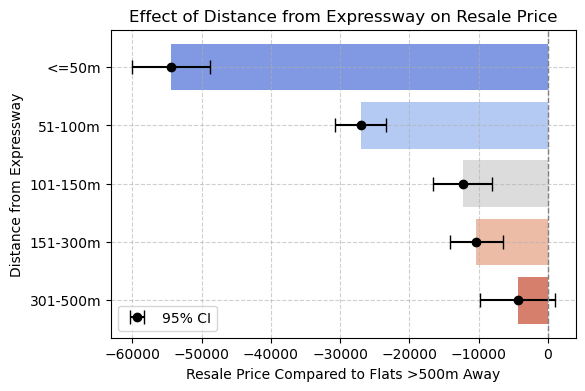

In [12]:
# Plot Coefficients with Error Bars
plt.figure(figsize=(6, 4))

summary_df = summary_df[summary_df['Variable'] != 'const'].copy()

# Rename the cells in the 'Variable' column for readability
new_variable_names = [
    '<=50m', 
    '51-100m', 
    '101-150m', 
    '151-300m',
    '301-500m'
]
summary_df['Variable'] = new_variable_names

# Create a bar plot for the coefficients
sns.barplot(x='coef', y='Variable', data=summary_df, palette='coolwarm')

# Add error bars
plt.errorbar(summary_df['coef'], summary_df['Variable'], 
             xerr=[summary_df['coef'] - summary_df['0.025'], summary_df['0.975'] - summary_df['coef']], 
             fmt='o', color='black', capsize=5, label='95% CI')

plt.xlabel('Resale Price Compared to Flats >500m Away')
plt.ylabel('Distance from Expressway')
plt.title('Effect of Distance from Expressway on Resale Price')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)  # Add vertical line at 0
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## 5.2 Linear Regression with Floor/Storey Information

In order to analyse the interaction of different floors/storeys on the resale flat prices, storey as well as distance-storey interaction features will be included into the regression model.

In [117]:
# Create interaction terms
distance_features = [
    'distance_from_expressway_<=50m', 
    'distance_from_expressway_51-100m', 
    'distance_from_expressway_101-150m', 
    'distance_from_expressway_151-300m', 
    'distance_from_expressway_301-500m'
]

storey_features = [
    'storey_range_category_High (19-30)', 
    'storey_range_category_Low-Mid (07-12)', 
    'storey_range_category_Mid (13-18)', 
    'storey_range_category_Very High (>30)'
]

# Create a new DataFrame for features and interaction terms
X = df_encoded[distance_features + storey_features].copy()

# Create interaction terms in the new DataFrame
for distance in distance_features:
    for storey in storey_features:
        X[f'{distance}_x_{storey}'] = df_encoded[distance] * df_encoded[storey]

# Add a constant to the new DataFrame for the intercept
X = sm.add_constant(X)

# Endogenous variable (resale price)
y = df_encoded['resale_price']

In [120]:
# Fit the linear regression model
model_floor_interaction = sm.OLS(y, X).fit()

# Generate summary of the regression results
model_floor_interaction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     1239.
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        01:16:06   Log-Likelihood:            -2.9586e+06
No. Observations:              220971   AIC:                         5.917e+06
Df Residuals:                  220941   BIC:                         5.918e+06
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
const                                                                      4.563e+05    565.030    807.513      0.000    4.55e+05    4.57e+05
distance_from_expressway_<=50m                                            -2.923e+04   3950.783     -7.400      0.000    -3.7e+04   -2.15e+04
distance_from_expressway_51-100m                                          -1.987e+04   2734.434     -7.267      0.000   -2.52e+04   -1.45e+04
distance_from_expressway_101-150m                                          -1.03e+04   3156.076     -3.263      0.001   -1.65e+04   -4111.463
distance_from_expressway_151-300m                                         -1.012e+04   2797.495     -3.618      0.000   -1.56e+04   -4638.356
distance_from_expressway_301-500m                                         -9373.4800   4051.857     -2.313      0.021   -1.73e+04   -1431.943
storey_range_category_High (19-30)                                         2.306e+05   1830.510    125.972      0.000    2.27e+05    2.34e+05
storey_range_category_Low-Mid (07-12)                                      2.823e+04    804.461     35.087      0.000    2.66e+04    2.98e+04
storey_range_category_Mid (13-18)                                          8.721e+04   1122.247     77.707      0.000     8.5e+04    8.94e+04
storey_range_category_Very High (>30)                                      4.527e+05   3900.792    116.063      0.000    4.45e+05     4.6e+05
distance_from_expressway_<=50m_x_storey_range_category_High (19-30)       -8.895e+04   1.78e+04     -5.006      0.000   -1.24e+05   -5.41e+04
distance_from_expressway_<=50m_x_storey_range_category_Low-Mid (07-12)    -2.691e+04   5770.682     -4.663      0.000   -3.82e+04   -1.56e+04
distance_from_expressway_<=50m_x_storey_range_category_Mid (13-18)        -2.333e+04   8731.750     -2.672      0.008   -4.04e+04   -6214.310
distance_from_expressway_<=50m_x_storey_range_category_Very High (>30)    -2.183e+05   4.42e+04     -4.944      0.000   -3.05e+05   -1.32e+05
distance_from_expressway_51-100m_x_storey_range_category_High (19-30)     -2.007e+04   8574.357     -2.340      0.019   -3.69e+04   -3261.363
distance_from_expressway_51-100m_x_storey_range_category_Low-Mid (07-12)  -8642.7371   3848.655     -2.246      0.025   -1.62e+04   -1099.470
distance_from_expressway_51-100m_x_storey_range_category_Mid (13-18)      -7927.0334   5545.811     -1.429      0.153   -1.88e+04    2942.617
distance_from_expressway_51-100m_x_storey_range_category_Very High (>30)  -8.833e+04   2.28e+04     -3.868      0.000   -1.33e+05   -4.36e+04
distance_from_expressway_101-150m_x_storey_range_category_High (19-30)     4.209e+04   9820.640      

In [132]:
# Extract coefficients and statistics
summary_df = pd.DataFrame({
    'coef': model_floor_interaction.params,
    'std err': model_floor_interaction.bse,
    't': model_floor_interaction.tvalues,
    'P>|t|': model_floor_interaction.pvalues,
    '0.025': model_floor_interaction.conf_int()[0],
    '0.975': model_floor_interaction.conf_int()[1]
})

# Reset the index to have the variable names as a column
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Variable'}, inplace=True)
summary_df.sort_values(by='Variable')   # sort by variable to make it more readable

# Display the summary DataFrame
summary_df


,Variable,coef,std err,t,P>|t|,0.025,0.975
0,const,456269.385118,565.030282,807.513153,0.000000e+00,455161.940048,457376.830189
1,distance_from_expressway_<=50m,-29234.676172,3950.782833,-7.399717,1.369552e-13,-36978.110655,-21491.241689
2,distance_from_expressway_51-100m,-19870.731360,2734.434407,-7.266852,3.691668e-13,-25230.153676,-14511.309044
3,distance_from_expressway_101-150m,-10297.291223,3156.075672,-3.262688,1.103776e-03,-16483.119760,-4111.462686
4,distance_from_expressway_151-300m,-10121.376695,2797.495469,-3.618014,2.969389e-04,-15604.397098,-4638.356291
5,distance_from_expressway_301-500m,-9373.479957,4051.856974,-2.313379,2.070274e-02,-17315.017201,-1431.942712
6,storey_range_category_High (19-30),230593.866603,1830.510115,125.972462,0.000000e+00,227006.113050,234181.620157
7,storey_range_category_Low-Mid (07-12),28226.055745,804.460506,35.086938,5.904510e-269,26649.333489,29802.778002
8,storey_range_category_Mid (13-18),87206.195176,1122.246820,77.706787,0.000000e+00,85006.619777,89405.770576
9,storey_range_category_Very High (>30),452736.442130,3900.792270,116.062690,0.000000e+00,445090.987887,460381.896373


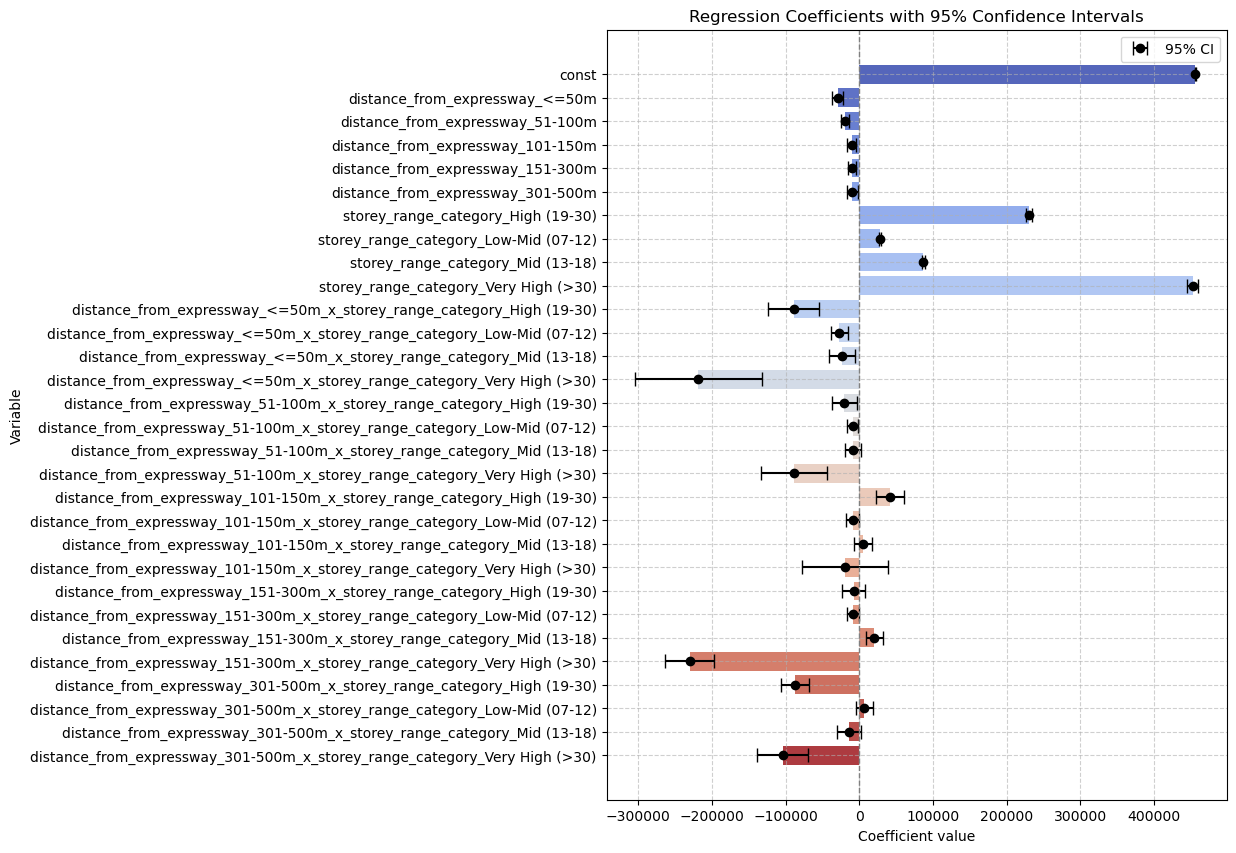

In [137]:
# Plot Coefficients with Error Bars
plt.figure(figsize=(8, 10))

# summary_df = summary_df[summary_df['Variable'] != 'const']

# Create a bar plot for the coefficients
sns.barplot(x='coef', y='Variable', data=summary_df, palette='coolwarm')

# Add error bars
plt.errorbar(summary_df['coef'], summary_df['Variable'], 
             xerr=[summary_df['coef'] - summary_df['0.025'], summary_df['0.975'] - summary_df['coef']], 
             fmt='o', color='black', capsize=5, label='95% CI')

plt.xlabel('Coefficient value')
plt.ylabel('Variable')
plt.title('Regression Coefficients with 95% Confidence Intervals')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)  # Add vertical line at 0
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Focusing on the interaction term of different floors for flats < 50m to an expressway, it is observed that the negative impact of being close to an expressway on resale price is more pronounced for higher-floor flats compared to those on other floors. 

The resale price for high-floor flats within 50m of an expressway is significantly lower than for flats at the same distance but in other storey categories.

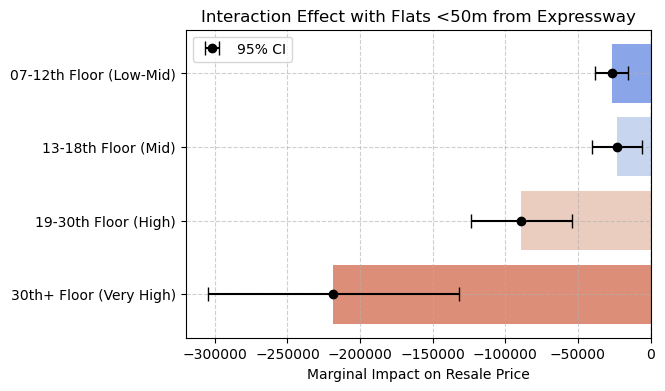

In [165]:
# Plot graph for interaction terms near highway (within 50m)
summary_df_near_highway = summary_df.iloc[10:14].copy()

# Rename the cells in the 'Variable' column for readability
new_variable_names = [
    '19-30th Floor (High)', 
    '07-12th Floor (Low-Mid)', 
    '13-18th Floor (Mid)', 
    '30th+ Floor (Very High)'
]
summary_df_near_highway['Variable'] = new_variable_names

# Sort by the 'Variable' column for readability
summary_df_near_highway = summary_df_near_highway.sort_values(by='Variable')

# Plot Coefficients with Error Bars
plt.figure(figsize=(6, 4))

# Create a bar plot for the coefficients
sns.barplot(x='coef', y='Variable', data=summary_df_near_highway, palette='coolwarm')

# Add error bars
plt.errorbar(summary_df_near_highway['coef'], summary_df_near_highway['Variable'], 
             xerr=[summary_df_near_highway['coef'] - summary_df_near_highway['0.025'], summary_df_near_highway['0.975'] - summary_df_near_highway['coef']], 
             fmt='o', color='black', capsize=5, label='95% CI')

plt.xlabel('Marginal Impact on Resale Price')
plt.ylabel('', labelpad=20)
plt.title('Interaction Effect with Flats <50m from Expressway')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)  # Add vertical line at 0
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 5.3 Analysis of Interaction with Flat Characteristics

In [214]:
# Define the new features related to flat characteristics
flat_features = [
    'flat_type_1 ROOM', 'flat_type_2 ROOM', 'flat_type_4 ROOM', 
    'flat_type_5 ROOM', 'flat_type_EXECUTIVE', 'flat_type_MULTI-GENERATION', 
    'floor_area_sqm', 'remaining_lease_years'
]

# Create interaction terms for storey and distance features in the new DataFrame
X = df_encoded[distance_features + storey_features].copy()
for distance in distance_features:
    for storey in storey_features:
        X[f'{distance}_x_{storey}'] = df_encoded[distance] * df_encoded[storey]

# Append interaction terms for distance and flat features to X
for distance in distance_features:
    for feature in flat_features:
        X[f'{distance}_x_{feature}'] = df_encoded[distance] * df_encoded[feature]

# Add the house-related features to X
X = X.join(df_encoded[flat_features])

# Add a constant to the model
X = sm.add_constant(X)


In [215]:
print(X.shape)

X

(220971, 78)


,const,distance_from_expressway_<=50m,distance_from_expressway_51-100m,distance_from_expressway_101-150m,distance_from_expressway_151-300m,distance_from_expressway_301-500m,storey_range_category_High (19-30),storey_range_category_Low-Mid (07-12),storey_range_category_Mid (13-18),storey_range_category_Very High (>30),...,distance_from_expressway_301-500m_x_floor_area_sqm,distance_from_expressway_301-500m_x_remaining_lease_years,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,floor_area_sqm,remaining_lease_years
0,1.0,0,0,0,0,0,0,1,0,0,...,0.0,0,0,1,0,0,0,0,44.0,61
1,1.0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,67.0,60
2,1.0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,67.0,62
3,1.0,0,0,0,1,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,68.0,62
4,1.0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,67.0,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220966,1.0,0,0,0,0,0,0,0,1,0,...,0.0,0,0,0,0,1,0,0,112.0,83
220967,1.0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0,1,0,0,122.0,70
220968,1.0,0,0,0,0,0,0,1,0,0,...,0.0,0,0,0,0,0,1,0,181.0,75
220969,1.0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0,0,1,0,146.0,71


In [216]:
# Print out all the column names
for row in sorted(X.columns.tolist()):
    print(row)

const
distance_from_expressway_101-150m
distance_from_expressway_101-150m_x_flat_type_1 ROOM
distance_from_expressway_101-150m_x_flat_type_2 ROOM
distance_from_expressway_101-150m_x_flat_type_4 ROOM
distance_from_expressway_101-150m_x_flat_type_5 ROOM
distance_from_expressway_101-150m_x_flat_type_EXECUTIVE
distance_from_expressway_101-150m_x_flat_type_MULTI-GENERATION
distance_from_expressway_101-150m_x_floor_area_sqm
distance_from_expressway_101-150m_x_remaining_lease_years
distance_from_expressway_101-150m_x_storey_range_category_High (19-30)
distance_from_expressway_101-150m_x_storey_range_category_Low-Mid (07-12)
distance_from_expressway_101-150m_x_storey_range_category_Mid (13-18)
distance_from_expressway_101-150m_x_storey_range_category_Very High (>30)
distance_from_expressway_151-300m
distance_from_expressway_151-300m_x_flat_type_1 ROOM
distance_from_expressway_151-300m_x_flat_type_2 ROOM
distance_from_expressway_151-300m_x_flat_type_4 ROOM
distance_from_expressway_151-300m_x_fl

In [217]:
# Fit the linear regression model
model_floor_flat_interaction = sm.OLS(y, X).fit()

# Generate summary of the regression results
model_floor_flat_interaction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     3594.
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        04:02:12   Log-Likelihood:            -2.8938e+06
No. Observations:              220971   AIC:                         5.788e+06
Df Residuals:                  220903   BIC:                         5.788e+06
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
const                                                                      2.052e+04   3400.024      6.037      0.000    1.39e+04    2.72e+04
distance_from_expressway_<=50m                                            -5.251e+04   1.78e+04     -2.944      0.003   -8.75e+04   -1.76e+04
distance_from_expressway_51-100m                                           1.876e+04   1.44e+04      1.304      0.192   -9431.467    4.69e+04
distance_from_expressway_101-150m                                          2.717e+04    1.7e+04      1.596      0.111   -6198.363    6.05e+04
distance_from_expressway_151-300m                                          8.581e+04   1.52e+04      5.641      0.000     5.6e+04    1.16e+05
distance_from_expressway_301-500m                                         -1.361e+04   1.78e+04     -0.764      0.445   -4.86e+04    2.13e+04
storey_range_category_High (19-30)                                         2.113e+05   1388.747    152.123      0.000    2.09e+05    2.14e+05
storey_range_category_Low-Mid (07-12)                                      2.617e+04    601.363     43.513      0.000     2.5e+04    2.73e+04
storey_range_category_Mid (13-18)                                          6.411e+04    864.784     74.137      0.000    6.24e+04    6.58e+04
storey_range_category_Very High (>30)                                      4.361e+05   2943.830    148.146      0.000     4.3e+05    4.42e+05
distance_from_expressway_<=50m_x_storey_range_category_High (19-30)       -1.068e+05   1.35e+04     -7.885      0.000   -1.33e+05   -8.03e+04
distance_from_expressway_<=50m_x_storey_range_category_Low-Mid (07-12)    -9103.7219   4319.876     -2.107      0.035   -1.76e+04    -636.874
distance_from_expressway_<=50m_x_storey_range_category_Mid (13-18)         3334.6470   6611.102      0.504      0.614   -9622.946    1.63e+04
distance_from_expressway_<=50m_x_storey_range_category_Very High (>30)     -2.47e+05   3.32e+04     -7.433      0.000   -3.12e+05   -1.82e+05
distance_from_expressway_51-100m_x_storey_range_category_High (19-30)     -2.864e+04   6594.279     -4.343      0.000   -4.16e+04   -1.57e+04
distance_from_expressway_51-100m_x_storey_range_category_Low-Mid (07-12)  -3206.2566   2879.956     -1.113      0.266   -8850.897    2438.384
distance_from_expressway_51-100m_x_storey_range_category_Mid (13-18)      -7095.4945   4259.966     -1.666      0.096   -1.54e+04    1253.931
distance_from_expressway_51-100m_x_storey_range_category_Very High (>30)  -1.191e+05   1.72e+04     -6.911      0.000   -1.53e+05   -8.53e+04
distance_from_expressway_101-150m_x_storey_range_category_High (19-30)     9219.2174   7505.716      

In [218]:
# Extract coefficients and statistics
summary_df = pd.DataFrame({
    'coef': model_floor_flat_interaction.params,
    'std err': model_floor_flat_interaction.bse,
    't': model_floor_flat_interaction.tvalues,
    'P>|t|': model_floor_flat_interaction.pvalues,
    '0.025': model_floor_flat_interaction.conf_int()[0],
    '0.975': model_floor_flat_interaction.conf_int()[1]
})

# Reset the index to have the variable names as a column
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Variable'}, inplace=True)
summary_df.sort_values(by='Variable')   # sort by variable to make it more readable

# Display the summary DataFrame
summary_df


,Variable,coef,std err,t,P>|t|,0.025,0.975
0,const,20524.795393,3400.023590,6.036663,1.575836e-09,13860.835097,27188.755689
1,distance_from_expressway_<=50m,-52512.875373,17837.752710,-2.943918,3.241199e-03,-87474.419809,-17551.330937
2,distance_from_expressway_51-100m,18755.887461,14381.488694,1.304169,1.921774e-01,-9431.466868,46943.241789
3,distance_from_expressway_101-150m,27170.642051,17025.222288,1.595905,1.105114e-01,-6198.363297,60539.647398
4,distance_from_expressway_151-300m,85811.871513,15212.043938,5.641048,1.692240e-08,55996.649900,115627.093126
...,...,...,...,...,...,...,...
73,flat_type_5 ROOM,63834.747634,2161.415971,29.533763,2.510364e-191,59598.426963,68071.068305
74,flat_type_EXECUTIVE,123283.786117,3224.456574,38.233973,0.000000e+00,116963.932734,129603.639500
75,flat_type_MULTI-GENERATION,241570.895402,13602.888281,17.758794,1.650234e-70,214909.578205,268232.212600
76,floor_area_sqm,2748.893754,39.200498,70.123950,0.000000e+00,2672.061769,2825.725739


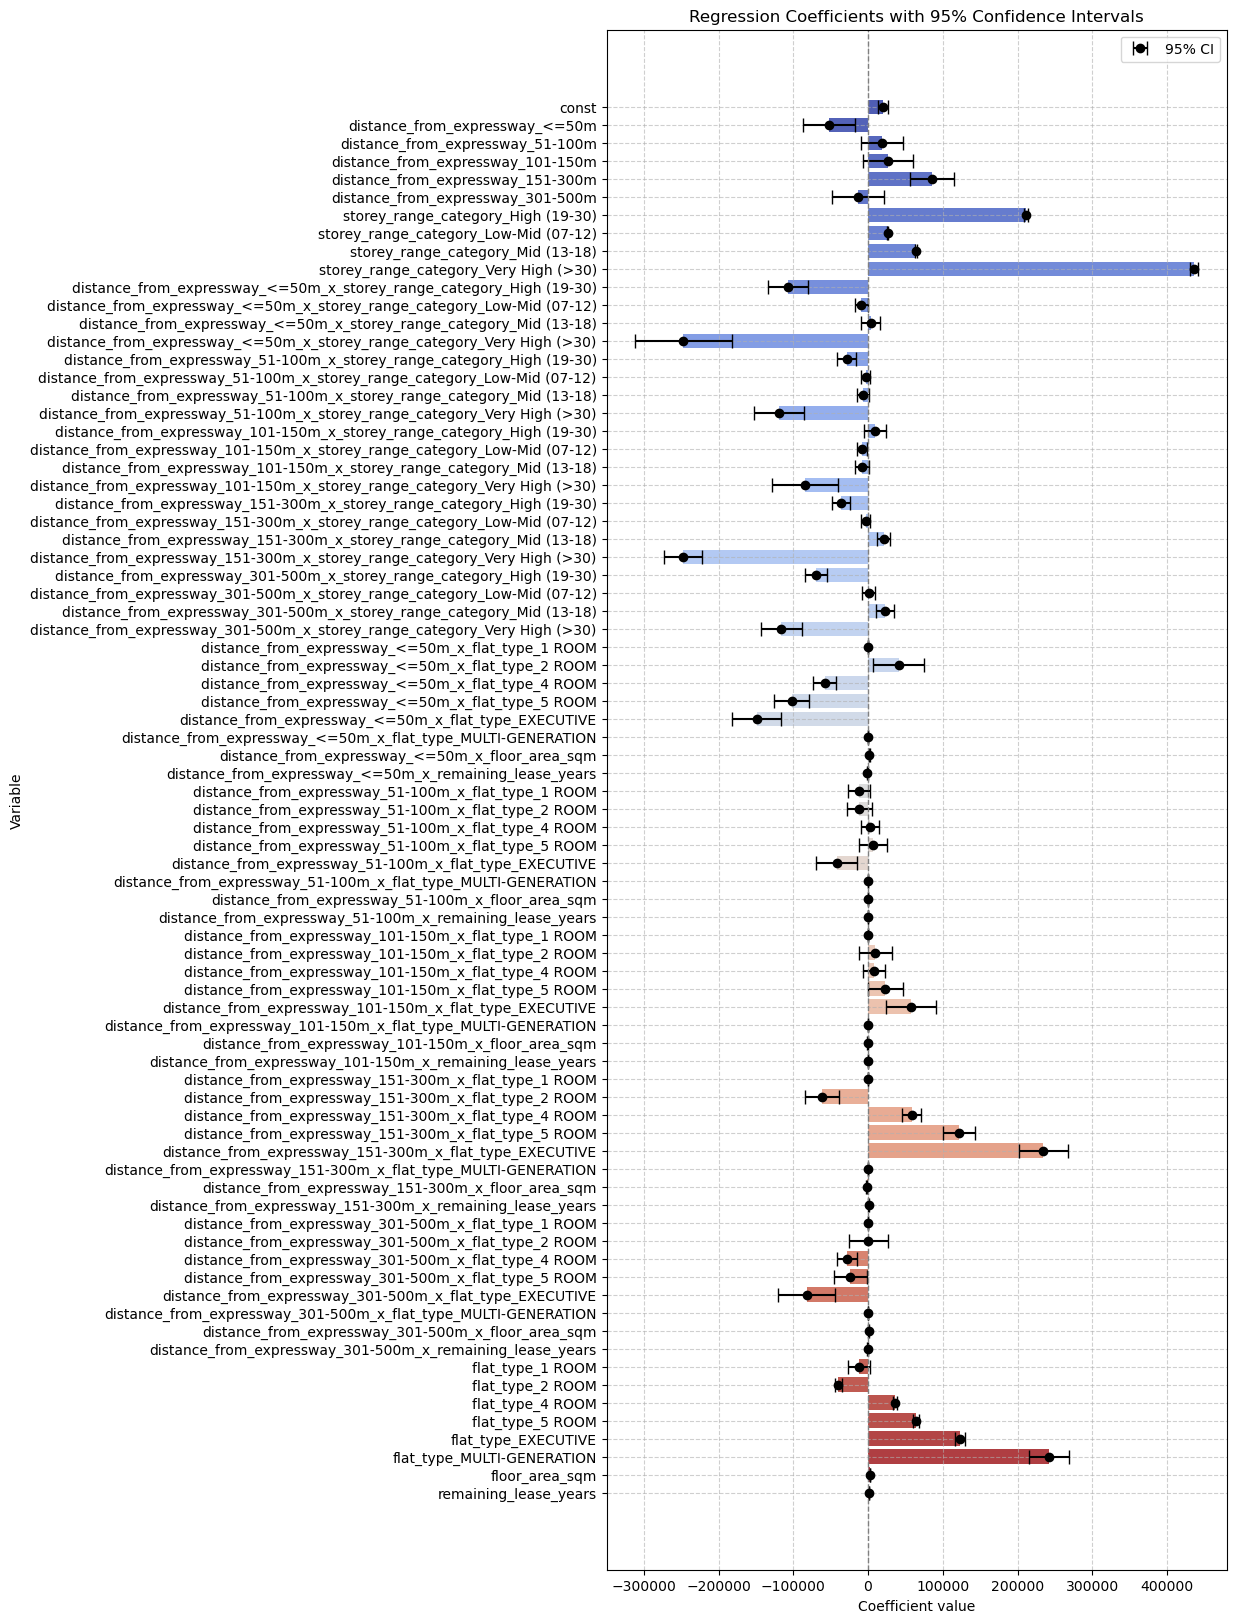

In [219]:
# Plot Coefficients with Error Bars
plt.figure(figsize=(8, 20))

# summary_df = summary_df[summary_df['Variable'] != 'const']

# Create a bar plot for the coefficients
sns.barplot(x='coef', y='Variable', data=summary_df, palette='coolwarm')

# Add error bars
plt.errorbar(summary_df['coef'], summary_df['Variable'], 
             xerr=[summary_df['coef'] - summary_df['0.025'], summary_df['0.975'] - summary_df['coef']], 
             fmt='o', color='black', capsize=5, label='95% CI')

plt.xlabel('Coefficient value')
plt.ylabel('Variable')
plt.title('Regression Coefficients with 95% Confidence Intervals')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)  # Add vertical line at 0
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


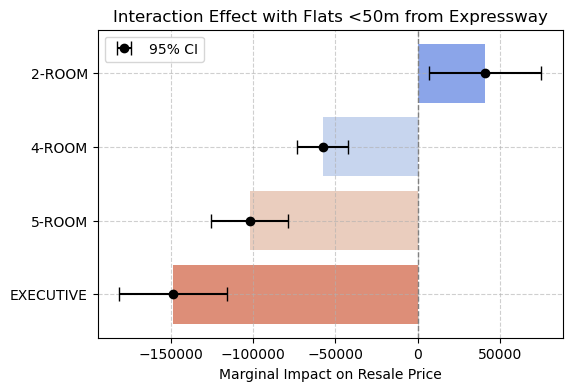

In [230]:
# Filtering the DataFrame
# Note: There are no 1-Room flats & Multi-generation flats within <50m from expressway, hence they are excluded
filtered_summary_df = summary_df[summary_df['Variable'].str.contains("distance_from_expressway_<=50m_x_flat_type")].iloc[1:-1].copy()

# Rename the cells in the 'Variable' column for readability
new_variable_names = [
    '2-ROOM', 
    '4-ROOM', 
    '5-ROOM', 
    'EXECUTIVE'
]
filtered_summary_df['Variable'] = new_variable_names


# Plot Coefficients with Error Bars
plt.figure(figsize=(6, 4))

# Create a bar plot for the coefficients
sns.barplot(x='coef', y='Variable', data=filtered_summary_df, palette='coolwarm')

# Add error bars
plt.errorbar(filtered_summary_df['coef'], filtered_summary_df['Variable'], 
             xerr=[filtered_summary_df['coef'] - filtered_summary_df['0.025'], filtered_summary_df['0.975'] - filtered_summary_df['coef']], 
             fmt='o', color='black', capsize=5, label='95% CI')

plt.xlabel('Marginal Impact on Resale Price')
plt.ylabel('')
plt.title('Interaction Effect with Flats <50m from Expressway')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)  # Add vertical line at 0
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

